# Week 9: Clustering of Masaeli et al.

We're going to reimplement an SVM model from a [Di Carlo lab's study of the mechanical properties of cells](https://www.nature.com/articles/srep37863). With this, we'll then explore some of its properties.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

mat = pd.read_csv('WBC_copy.csv')
mat.drop('Unnamed: 0', axis=1, inplace=True)
mat.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,Sample
0,7.705763,0.991449,0.023529,41.733333,1.048193,43.5,5,68.713823,0.781410,0.869809,41.605769,5.0,0.999950,50.6,11,56.8,9,5,0.000000,WBC
1,296.676531,3.069244,0.515789,55.275000,3.130435,108.0,155,271.802401,0.885943,0.820493,56.551683,5.0,0.893470,76.3,8,668.3,9,25,0.037783,WBC
2,537.484884,1.001452,0.058824,42.800000,1.125000,40.5,280,75.633843,0.843340,0.835149,42.076923,5.0,0.999243,50.5,7,36.6,11,3,0.000000,WBC
3,701.235607,1.130061,0.107527,46.266667,1.240964,51.5,365,90.187681,0.705554,0.846169,47.645833,5.0,0.999204,60.4,6,62.7,7,11,0.021176,WBC
4,720.500015,0.995128,0.023256,39.875000,1.047619,44.0,375,65.618147,0.847418,0.831938,44.894231,4.5,0.989088,73.4,9,40.5,8,7,0.000000,WBC


#### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells of differing type?

It shows that there is not a clear sepeartion of the three classes based on any two variables


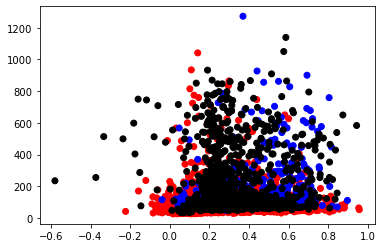

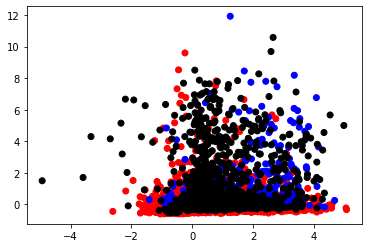

In [2]:
# Answer
Mat = mat.to_numpy()
Vars = (Mat[:,:19])
colorlist = []

for VI in zip(mat.V1, mat.V2, mat.Sample):
    if VI[2] == "WBC":
        colorlist.append('r')
    elif VI[2]=="HL60":
        colorlist.append('b')
    elif VI[2] == "MCF7":
        colorlist.append('k')
        
plt.scatter(mat.V3, mat.V14, c = colorlist)
plt.figure()

print("It shows that there is not a clear sepeartion of the three classes based on any two variables")

scaler = preprocessing.StandardScaler().fit(Mat[:,:19])
scaled_Vars = scaler.transform(Mat[:,:19])

plt.scatter(scaled_Vars[:,2], scaled_Vars[:,13], c = colorlist)

The above plot shows that there does not seem to be any clear separation of classes in 2 Dimensions, this means we may be able to seperate these in higher dimensions, if there are not points that are exactly the same between classes. However, given how tight the clusters seem it is likely some points are unable to be seperated entirely even at higher dimensions using a linear cut. Therefore, we may need to change the kernel or basis of this in order to seperate the classes. 

#### (2) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

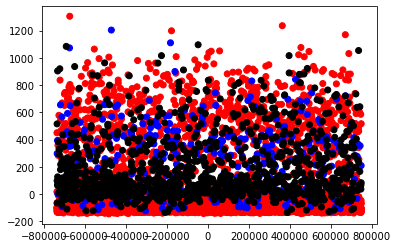

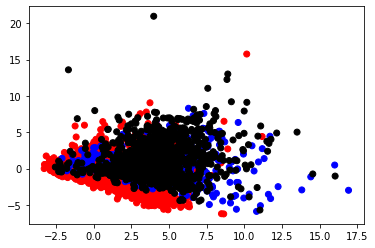

In [3]:
# Answer
Mat = mat.to_numpy()
Vars = (Mat[:,:19])
scaler = preprocessing.StandardScaler().fit(Mat[:,:19])
scaled_Vars = scaler.transform(Mat[:,:19])
labels = Mat[:,19]
ncomp = 10
pca = PCA(n_components=ncomp)
SVM_PCA = pca.fit_transform(Vars)
SSVM_PCA = pca.fit_transform(scaled_Vars)

plt.scatter(SVM_PCA[:, 0], SVM_PCA[:, 1], c = colorlist)

plt.figure()
plt.scatter(SSVM_PCA[:, 0], SSVM_PCA[:, 1], c = colorlist)

Plotting the first two principal components does spread out the data a bit, but it is still not possible to distinguish classes from this technique alone. It tells us that the class cannot be sepearated by max variance alone most likely. The classes definetly have overlap between them and may be related to eachother or have covariance. It is not possible to seperate these classes using only two dimensions.

#### (3) How does partial least squares regression fare in discriminating cancer and non-cancer cells (make cancer=1 and non-cancer=0; this is called PLS-DA)? How does this relate to the results in the previous questions?

The graph below shows that even when taking into account all the possible dimensions that it is impossible to account for all of the variance in the data. It also shows how in the previous data that the first two components only explain 67% confirming that those two components do not have great explanation of the data. 

Array of Percentage of variance in prediction explained by the sum of total PCAs:  [0.5876867  0.6717032  0.68142963 0.68606013 0.68930113 0.69147025
 0.69269008 0.6929857  0.69302842 0.69304711 0.69305119 0.69305274
 0.69305403 0.69305484 0.69305523 0.69305556 0.69305615 0.69305618]


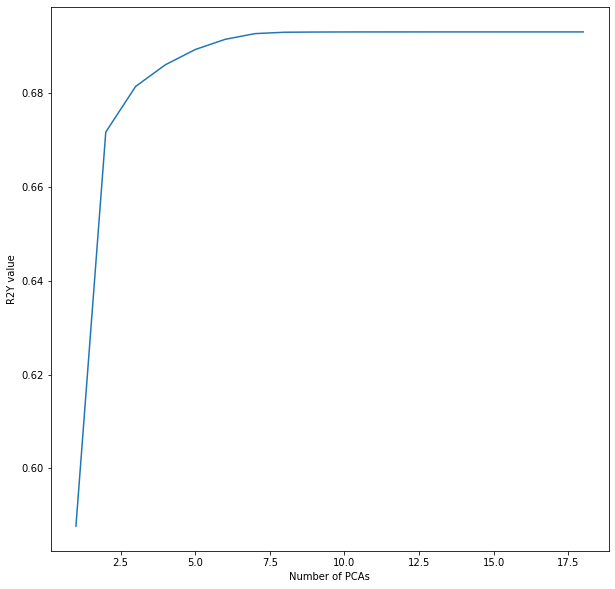

In [4]:
# Answer
Mat = mat.to_numpy()
Vars = (Mat[:,:19])
scaler = preprocessing.StandardScaler().fit(Mat[:,:19])
scaled_Vars = scaler.transform(Mat[:,:19])

Cancer_Cell = []
Healthy_Cell = []
X_S = scaled_Vars

for VII in zip(mat.V1, mat.V2, mat.Sample):
    if VII[2] == "WBC":
        Cancer_Cell.append(0)
        Healthy_Cell.append(1)
    elif VII[2]=="HL60":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)
    elif VII[2] == "MCF7":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)


Cancer_Cell = np.array(Cancer_Cell)
Y_S = (Cancer_Cell)

R2Y = []
#print(Y_S)
for n in range (1, 19):
    pls = PLSRegression(n_components = n, scale=True, max_iter=500, tol=1e-06, copy=True)
    pls.fit_transform(X_S, Y_S)
    r2 = pls.score(X_S, Y_S)
    R2Y = np.append(R2Y, r2)

pcas = np.arange(1,19,1)   
fig = plt.figure(figsize = (10,10))
plt.plot(pcas,R2Y)
plt.xlabel("Number of PCAs")
plt.ylabel("R2Y value")



print("Array of Percentage of variance in prediction explained by the sum of total PCAs: " , R2Y)


#### (4) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer.

Evaluate how well this performs.

Changing the various this SVM shows that the SVM is able to seperate the data way better than pca could. It is able to seperate the data with an average cross validated score of 96% and from the confusion matrix have a specificity of 0.99 and a sensitivity of 0.85. 

In [5]:
# Answer
Mat = mat.to_numpy()
Vars = (Mat[:,:19])
scaler = preprocessing.StandardScaler().fit(Mat[:,:19])
scaled_Vars = scaler.transform(Mat[:,:19])

Cancer_Cell = []
Healthy_Cell = []
X_S = scaled_Vars

for VII in zip(mat.V1, mat.V2, mat.Sample):
    if VII[2] == "WBC":
        Cancer_Cell.append(0)
        Healthy_Cell.append(1)
    elif VII[2]=="HL60":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)
    elif VII[2] == "MCF7":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)


Cancer_Cell = np.array(Cancer_Cell)
Y_S = (Cancer_Cell)
print(np.size(X_S, 1))
print(np.size(Y_S,0))

19
10108


In [6]:
model_HW = SVC(kernel='linear', C=1)
model_HW.fit(X_S, Y_S)

SVC(C=1, kernel='linear')

In [7]:
skf = 5

cvp = cross_val_predict(model_HW, X_S, Y_S, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW, X_S, Y_S, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW.decision_function(X_S))
print()

print("Confusion Matrix:")
pred = model_HW.predict(X_S)
confusion_matrix(Y_S, pred)

cross-validated estimated class for each input data point
[0 0 0 ... 1 1 1]
score by cross-validation:
[0.93521266 0.97428289 0.98219585 0.97674419 0.97971301]
Average Score across all folds:
0.9696297188129975

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-2.2990688  -0.93123087 -2.286042   ...  0.67688003  3.38425725
  2.21831107]

Confusion Matrix:


array([[8546,   83],
       [ 212, 1267]], dtype=int64)

#### (5) Choose and justify your selection of a different kernel to use in SVM classification. (Hint: It should be a kernel with varying complexity, such as polynomial or RBF.)

The best model of the proposed models below models below, is the rbf kernel with a regression factor of (C=1), because it gives us the highest average cross validated score will not perfectly fitting the test data (and lowering the average cross validated score, caused by overfitting) and also having the best sensitivity and specificity from the confusion matrix. 

In [8]:
# Answer
model_HW_rbf = SVC(kernel='rbf', C=1)
model_HW_rbf.fit(X_S, Y_S)

SVC(C=1)

In [9]:
skf = 5

cvp = cross_val_predict(model_HW_rbf, X_S, Y_S, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_rbf, X_S, Y_S, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_rbf.decision_function(X_S))
print()

print("Confusion Matrix:")
pred = model_HW_rbf.predict(X_S)
confusion_matrix(Y_S, pred)

cross-validated estimated class for each input data point
[0 1 0 ... 1 1 1]
score by cross-validation:
[0.93372898 0.97082097 0.98417409 0.97476497 0.97525977]
Average Score across all folds:
0.9677497551671838

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-1.07943764 -0.95822344 -1.15637346 ...  0.68094877  1.59467285
  1.78875959]

Confusion Matrix:


array([[8601,   28],
       [ 155, 1324]], dtype=int64)

In [10]:
model_HW_poly = SVC(kernel='poly', C=1)
model_HW_poly.fit(X_S, Y_S)

SVC(C=1, kernel='poly')

In [11]:
skf = 5

cvp = cross_val_predict(model_HW_poly, X_S, Y_S, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_poly, X_S, Y_S, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_poly.decision_function(X_S))
print()

print("Confusion Matrix:")
pred = model_HW_poly.predict(X_S)
confusion_matrix(Y_S, pred)

cross-validated estimated class for each input data point
[0 1 0 ... 1 1 1]
score by cross-validation:
[0.92433234 0.96785361 0.97181009 0.9673429  0.97179614]
Average Score across all folds:
0.9606270167200869

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-1.40118601 -0.9998971  -1.50069459 ...  1.35645216 10.05289543
  5.44247406]

Confusion Matrix:


array([[8619,   10],
       [ 182, 1297]], dtype=int64)

#### (6) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on cross-validation.

How does the answer of which classification strategy vary based on whether you are performing cross-validation?

By varying the data and looking at cross-validation vs the single test prediction error, we can determine the best performing model, when it has a high cross validated score, and high sensitivity and spceficity on a single test. And we see that these are inversely related at the extremes, if we make the test really good at predicting only one case, we get errors in the cross validated test. If we make the test really (loose) good at only the cross validated test, it will give us greater amounts of false positive and false negatives in the individual test. This is like the bias variance trade off, and we are looking for the most specific model that does not overfit the data. 

In [12]:
model_HW_poly_5 = SVC(kernel='poly', C=1, degree = 5)
model_HW_poly_5.fit(X_S, Y_S)

SVC(C=1, degree=5, kernel='poly')

In [13]:
# Answer
skf = 5

cvp = cross_val_predict(model_HW_poly_5, X_S, Y_S, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_poly_5, X_S, Y_S, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_poly_5.decision_function(X_S))
print()

print("Confusion Matrix:")
pred = model_HW_poly_5.predict(X_S)
confusion_matrix(Y_S, pred)

cross-validated estimated class for each input data point
[0 1 0 ... 1 1 1]
score by cross-validation:
[0.92087043 0.95400593 0.96439169 0.956952   0.95992083]
Average Score across all folds:
0.9512281773328615

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-1.33286773 -0.99999492 -1.3827088  ...  4.21438864 39.6075785
  6.0765518 ]

Confusion Matrix:


array([[8627,    2],
       [ 180, 1299]], dtype=int64)

In [14]:
model_HW_rbf_2 = SVC(kernel='rbf', C=1E10)
model_HW_rbf_2.fit(X_S, Y_S)

SVC(C=10000000000.0)

In [15]:
skf = 5

cvp = cross_val_predict(model_HW_rbf_2, X_S, Y_S, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_rbf_2, X_S, Y_S, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_rbf_2.decision_function(X_S))
print()

print("Confusion Matrix:")
pred = model_HW_rbf_2.predict(X_S)
confusion_matrix(Y_S, pred)

cross-validated estimated class for each input data point
[1 0 0 ... 1 1 1]
score by cross-validation:
[0.73986152 0.9322453  0.95548961 0.94458189 0.89905987]
Average Score across all folds:
0.8942476401346691

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-5.76691595 -1.00014406 -7.37691765 ...  5.48263836  4.09689762
  4.82716663]

Confusion Matrix:


array([[8629,    0],
       [   0, 1479]], dtype=int64)

#### (7) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

I did this by changing the test and training splits so that the model was trained on less data, therefore making it seem like less data was collected. Then when this model was tested against the test data it performed just as well, so she can do this. 

In [16]:
Mat = mat.to_numpy()
Vars = (Mat[:,:19])
scaler = preprocessing.StandardScaler().fit(Mat[:,:19])
scaled_Vars = scaler.transform(Mat[:,:19])

Cancer_Cell = []
Healthy_Cell = []
X_S = scaled_Vars

for VII in zip(mat.V1, mat.V2, mat.Sample):
    if VII[2] == "WBC":
        Cancer_Cell.append(0)
        Healthy_Cell.append(1)
    elif VII[2]=="HL60":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)
    elif VII[2] == "MCF7":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)


Cancer_Cell = np.array(Cancer_Cell)
Y_S = (Cancer_Cell)
print(np.size(X_S, 1))
print(np.size(Y_S,0))

19
10108


In [17]:
# Answer
#I can do this by building the model on a smaller training set and then testing it on a larger set to see 
#how well it still classifies the data.
X_train, X_test, y_train, y_test = train_test_split(X_S, Y_S, test_size=0.90, random_state=42, stratify = Y_S )
model_HW_rbf_tt = SVC(kernel='rbf', C=1)
model_HW_rbf_tt.fit(X_train, y_train)



SVC(C=1)

In [18]:
skf = 5

cvp = cross_val_predict(model_HW_rbf_tt, X_test, y_test, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_rbf_tt, X_test, y_test, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_rbf_tt.decision_function(X_test))
print()

print("Confusion Matrix:")
pred = model_HW_rbf_tt.predict(X_test)
confusion_matrix(y_test, pred)

cross-validated estimated class for each input data point
[0 0 0 ... 0 1 0]
score by cross-validation:
[0.97087912 0.97252747 0.97087912 0.97141286 0.97471138]
Average Score across all folds:
0.9720819916751747

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-1.45613862 -0.27442897 -1.21994061 ... -1.43660134  2.06810163
 -1.49576622]

Confusion Matrix:


array([[7649,  118],
       [ 179, 1152]], dtype=int64)

#### (8) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent? Try this with one cell population.

I attempted this on the healthy cell population below and it seems that the number of cells in the groupings is not highly sensitive to the group numbers. It may be different if you were to remove a whole group or almost an entire group, but if you were keeping the cross validation stratified, you would not see much of a change in cross validation. Therefore, it seems it is not sensitive to the cell population. 

In [19]:
# Answer
Mat = mat.to_numpy()

wbc =mat.loc[mat['Sample'] == "WBC"]
hl =mat.loc[mat['Sample'] == "HL60"]
mc =mat.loc[mat['Sample'] == "MCF7"]

i = 0
j = 0
k = 0
for VJ in (mat.Sample):
    if VJ == "WBC":
        i = i +1
    elif VJ=="HL60":
        j = j +1
    elif VJ == "MCF7":
        k = k +1
        
print(i, j, k)

WBC = np.zeros([4316, 20])
HL60 = np.zeros([322, 20])
MCF7 = np.zeros([1157, 20])

wbc_half = wbc.loc[0:4316]
WBC_H = wbc_half.to_numpy()
HL60 = hl.to_numpy()
MCF7 = mc.to_numpy()

df1 = wbc_half.append(hl)
df_test = df1.append(mc)

test_new = np.append(WBC_H, HL60,0)
test_new = np.append(test_new, MCF7,0)
print(test_new)




8629 322 1157
[[7.705762982 0.991449117 0.023529412 ... 5 0.0 'WBC']
 [296.6765314 3.069243717 0.515789474 ... 25 0.037782722 'WBC']
 [537.4848843 1.001452451 0.058823529 ... 3 0.0 'WBC']
 ...
 [1317821.402 1.283510472 0.141818182 ... 14 0.014726313 'MCF7']
 [1317917.726 0.852800337 0.191740413 ... 19 0.021743189 'MCF7']
 [1318017.902 0.862816227 0.252525253 ... 3 0.0 'MCF7']]


In [20]:
scaler = preprocessing.StandardScaler().fit(test_new[:,:19])
scaled_Vars = scaler.transform(test_new[:,:19])

Cancer_Cell = []
Healthy_Cell = []
X_S_t = scaled_Vars

for VII in df_test["Sample"]:
    if VII == "WBC":
        Cancer_Cell.append(0)
        Healthy_Cell.append(1)
    elif VII=="HL60":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)
    elif VII == "MCF7":
        Cancer_Cell.append(1)
        Healthy_Cell.append(0)


Cancer_Cell_t = np.array(Cancer_Cell)
Y_S_t = (Cancer_Cell_t)
print(np.size(X_S_t, 1))
print(np.size(Y_S_t,0))

model_HW_rbf_new_t = SVC(kernel='rbf', C=1)
model_HW_rbf_new_t.fit(X_S_t, Y_S_t)

skf = 5

cvp = cross_val_predict(model_HW_rbf_new_t, X_S_t, Y_S_t, cv = skf)
print("cross-validated estimated class for each input data point")
print(cvp)

cvs = cross_val_score(model_HW_rbf_new_t, X_S_t, Y_S_t, cv = skf)
print("score by cross-validation:")
print(cvs)
print("Average Score across all folds:")
print(np.sum(cvs)/np.size(cvs))
print()
#print("area under ROC:")
#print(roc_auc_score(y_a, model.predict_proba(GEC_R3404_S1)[:,1]))

print("Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane")
print(model_HW_rbf_new_t.decision_function(X_S_t))
print()

print("Confusion Matrix:")
pred = model_HW_rbf_new_t.predict(X_S_t)
confusion_matrix(Y_S_t, pred)

19
5796
cross-validated estimated class for each input data point
[0 0 0 ... 1 1 1]
score by cross-validation:
[0.92931034 0.96031061 0.97756687 0.98101812 0.9732528 ]
Average Score across all folds:
0.9642917497247925

Signed (labeled psotive or negative based on side of hyperplane) proportional distance from hyperplane
[-1.08778513 -0.99994056 -1.22979976 ...  1.33047522  1.33464171
  2.32618789]

Confusion Matrix:


array([[4292,   25],
       [  85, 1394]], dtype=int64)

#### (9) You want to save your fit model, but want to reduce it so that you don't have to carry around all the data points. Which points could you remove and still have the same SVM model in the end?

Answer
You could remove any of the points as long as you kept just the support vectors. The SVM model is only described by the three support vectors, so removing all other points will not affect the model at all. 

#### (10) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or worse than before? Why?

# Answer
I would expect the model to perform as well or slightly better than the cross validated average score percentage. This is because these cross validated models were trained and tested repeatedly over stratified group, meaning that each trained data had no knowledge of the test data. And because these models were built on a lower amount of training data than the real model the average prediction error would be higher. Therefore, I would expect the true model to perform slightly better. 

#### (11) As a prior distribution, assume that, among patients coming in for testing, 99% are cancer-free in the end. Estimate how well your assay needs to perform for 90% of positive tests to in fact have cancer.

# Answer
Using Bayesian statistics. 
If the prior 0.99 for having cancer and and our desired True positive rate is 0.9, that means if we had 1000 patients come to take the test, on average 10 would have cancer and 990 would not have cancer. We would want a Treu positive rate of 0.9 meaning for every 1 False positve there would be 9 True positives. If we take this ration and apply it to the prior and the hypothetical case, we see that there would be 9 true positives, and 1 false positive. Then the amount of false negatives would be 1 and the amount of true negatives would be 989. Therefore the assay would have to be 90% sensitive and 99.9% specific. 